# “Hello, world!”

Import Sionna:

In [2]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

Let us first create a [BinarySource](https://nvlabs.github.io/sionna/phy/api/mapping.html#sionna.phy.mapping.BinarySource) to generate a random batch of bit vectors that we can map to constellation symbols:

In [3]:
batch_size = 1000 # Number of symbols we want to generate
num_bits_per_symbol = 4 # 16-QAM has four bits per symbol
binary_source = sionna.phy.mapping.BinarySource()
b = binary_source([batch_size, num_bits_per_symbol])
b

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[0., 0., 1., 1.],
       [1., 1., 0., 1.],
       [0., 1., 1., 0.],
       ...,
       [1., 1., 0., 0.],
       [1., 0., 1., 1.],
       [1., 0., 0., 1.]], dtype=float32)>

Next, let us create a [Constellation](https://nvlabs.github.io/sionna/phy/api/mapping.html#sionna.phy/mapping.Constellation) and visualize it:

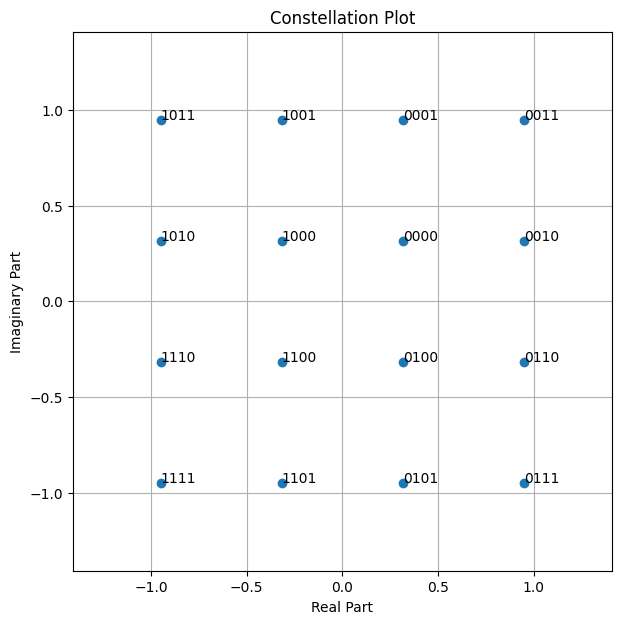

In [4]:
constellation = sionna.phy.mapping.Constellation("qam", num_bits_per_symbol)
constellation.show();

We now need a [Mapper](https://nvlabs.github.io/sionna/phy/api/mapping.html#sionna.phy.mapping.Mapper) that maps each row of b to the constellation symbols according to the bit labeling shown above.

In [5]:
mapper = sionna.phy.mapping.Mapper(constellation=constellation)
x = mapper(b)
x[:10]

<tf.Tensor: shape=(10, 1), dtype=complex64, numpy=
array([[ 0.94868326+0.94868326j],
       [-0.31622776-0.94868326j],
       [ 0.94868326-0.31622776j],
       [-0.31622776+0.31622776j],
       [-0.94868326+0.94868326j],
       [-0.31622776+0.31622776j],
       [-0.94868326+0.94868326j],
       [-0.31622776-0.94868326j],
       [-0.31622776+0.94868326j],
       [-0.31622776-0.94868326j]], dtype=complex64)>

Let us now make things a bit more interesting a send our symbols over and [AWGN channel](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.phy.channel.AWGN):

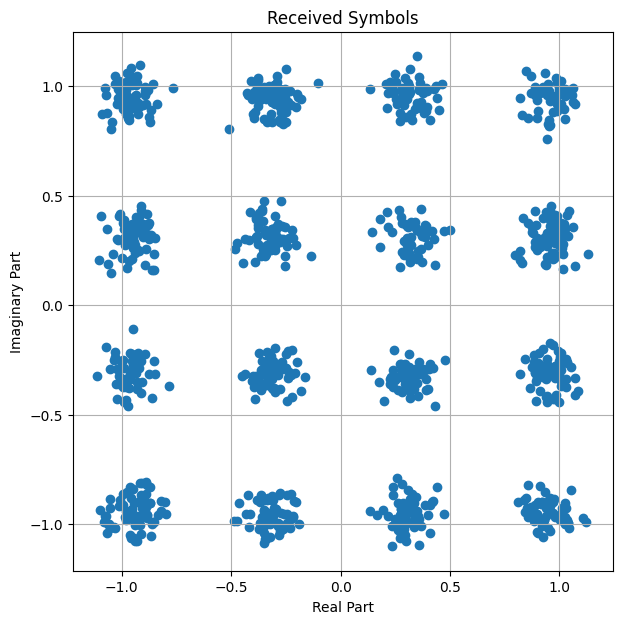

In [6]:
awgn = sionna.phy.channel.AWGN()
ebno_db = 15 # Desired Eb/No in dB
no = sionna.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1)
y = awgn(x, no)

# Visualize the received signal
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.scatter(np.real(y), np.imag(y));
ax.set_aspect("equal", adjustable="box")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True, which="both", axis="both")
plt.title("Received Symbols");